In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724

/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724


In [ ]:
!pip install fmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 10.6 MB/s eta 0:00:00


In [ ]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from fmpy.util import plot_result, download_test_file
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

import random
import numpy as np
import torch
import argparse
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras

from collections import deque
import numpy as np
from tqdm import tqdm

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import scipy.signal
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch import FloatTensor as FT

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from torch.utils.tensorboard import SummaryWriter

In [ ]:
fmu_filename = 'HEV_TMED_Simulator_Rearrange_230711_linux.fmu'
start_time = 0.0
stop_time = 1800.0
step_size = 1
soc_init = 67

# WLTP profile에 대하여 시험
with open("wltp_vehicle_speed_profile_real.csv") as file_name:
    vehicle_speed_profile = np.loadtxt(file_name, delimiter=",")

EngLine = pd.read_csv('wltp_EngLine_rule_based_10Hz.csv')
EngLine = np.array(EngLine['EngLine'])

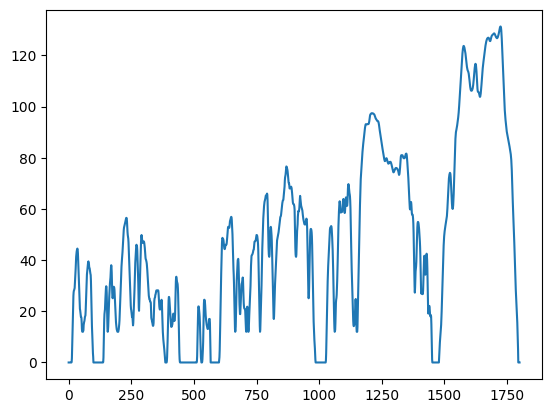

In [ ]:
# plt.plot(vehicle_speed_profile)
plt.plot(vehicle_speed_profile[:,1])

In [ ]:
class HEV:
    def __init__(self, fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile):
        self.fmu_filename = fmu_filename
        self.vrs = {}
        self.start_time = start_time
        self.stop_time = stop_time
        self.step_size = step_size
        self.time = self.start_time
        self.vehicle_speed_profile = vehicle_speed_profile
        self.soc_init = soc_init/5000
        self.soc_base = soc_init/5000
        self.state_init = np.array([self.soc_init, 0, 0]).reshape(1,-1)
        self.state = np.array([self.soc_init, 0, 0]).reshape(1,-1)
        self.action_upper_bound = 15000
        self.action_lower_bound = -15000
        #self.action_space = [[13500, 2000], [500, 2000], [13500, -15000], [500, -15000]]
        self.obssize = len(self.state[0])
        self.actsize = 2

        model_description = read_model_description(self.fmu_filename)
        for variable in model_description.modelVariables:
            self.vrs[variable.name] = variable.valueReference
        unzipdir = extract(fmu_filename)
        self.fmu = FMU2Slave(guid=model_description.guid,
                       unzipDirectory=unzipdir,
                       modelIdentifier=model_description.coSimulation.modelIdentifier,
                       instanceName='instance1')

    def step(self, action):
        #a = self.action_space[action]
#         action = action*self.action_upper_bound
        a1 = action[0]*self.action_upper_bound
        a2 = action[0]*self.action_upper_bound
        a3 = self.soc_init*5000
        a4 = action[1]/2 + 1
        instant_veh_speed = np.interp(self.time, self.vehicle_speed_profile[:,0], self.vehicle_speed_profile[:,1])
        self.fmu.setReal([self.vr_input1, self.vr_input2, self.vr_input3, self.vr_input4, self.vr_input5], [instant_veh_speed, a1, a2, a3, a4]) #input variable, input key(13500 2000)
        self.fmu.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size)
#         [output1, output2, output3, output4, output5, output6, output7] = self.fmu.getReal([self.vr_output1,self.vr_output2, self.vr_output3, self.vr_output4, self.vr_output5, self.vr_output6, self.vr_output7])
#         self.state = [output1, output2, output3, output4, output5, output6, output7]
        state = np.array(self.fmu.getReal(np.arange(35)))/5000
        state_column = np.array([self.vrs['Bat_SOC'], self.vrs['BSFC_g_kWh[1]'], self.vrs['Driver_sVeh_kph']])
        self.state = state[state_column]
        soc = state[self.vrs['Bat_SOC']]
        BSFC = state[self.vrs['BSFC_g_kWh[1]']]
        reward = 1 - 10000*(self.soc_init - soc) ** 2 - BSFC
        is_done = lambda time: time >= self.stop_time
        info = state[np.array([self.vrs['Bat_SOC'], self.vrs['nEngOn'], self.vrs['PT_tqTmInDmd_Nm_P2'], self.vrs['ObEng_nEng_Rpm'], self.vrs['TrEtp_tqEngMAF_Nm'], self.vrs['TrP0_tqP0_Nm'], self.vrs['TrP2_tqP2_Nm'], self.vrs['Driver_sVeh_kph'], self.vrs['BSFC_g_kWh[1]']])]
        self.time += self.step_size
        return self.state.reshape(1,-1), reward, is_done(self.time), info

    def reset(self):

        self.fmu.instantiate()
        self.fmu.setupExperiment(startTime=self.start_time)
        self.fmu.enterInitializationMode()
        self.fmu.exitInitializationMode()
        self.state = self.state_init
        self.time = self.start_time

        self.vr_input1 = self.vrs['Driver_sVeh_Target_kph']
        self.vr_input2 = self.vrs['Engine_on_line']
        self.vr_input3 = self.vrs['Engine_off_line']
        self.vr_input4 = self.vrs['soc_init']
        self.vr_input5 = self.vrs['Engine_OOL']
        self.vr_output1 = self.vrs['TgMod_fPt']
        self.vr_output2 = self.vrs['P2_wElec_W']
        self.vr_output3 = self.vrs['P4_wElec_W']
        self.vr_output4 = self.vrs['ObP2_wElecBIntv_W']
        self.vr_output5 = self.vrs['EV_on_line']
        self.vr_output6 = self.vrs['EV_off_line']
        self.vr_output7 = self.vrs['Bat_SOC']
        self.vr_output8 = self.vrs['PT_tqTmInDmd_Nm_P2']
        self.vr_output9 = self.vrs['P0_wElec_W']
        self.vr_output10 = self.vrs['Pwr_Aux_W']
        self.vr_output11 = self.vrs['ObEng_nEng_Rpm']
        self.vr_output12 = self.vrs['TrEtp_tqEngMAF_Nm']
        self.vr_output13 = self.vrs['rpm_P0']
        self.vr_output14 = self.vrs['TM_F_nTmIn_rpm']
        self.vr_output15 = self.vrs['TM_R_nTmIn_rpm']
        self.vr_output16 = self.vrs['eBat_kWh']
        self.vr_output17 = self.vrs['nEngOn']
        self.vr_output18 = self.vrs['TrP0_tqP0_Nm']
        self.vr_output19 = self.vrs['TrP2_tqP2_Nm']
        self.vr_output20 = self.vrs['TrP4_tqP4_Nm']
        self.vr_output21 = self.vrs['TCU_F_fCurGe']
        self.vr_output22 = self.vrs['TCU_F_fTarGe']
        self.vr_output23 = self.vrs['Driver_sVeh_kph']
        self.vr_output24 = self.vrs['Eng_eff_avg']
        self.vr_output25 = self.vrs['TM_F_P0P2_eff_avg']
        self.vr_output26 = self.vrs['TM_F_P0P4_eff_avg']
        self.vr_output27 = self.vrs['BSFC_g_kWh[1]']
        self.vr_output28 = self.vrs['BSFC_g_kWh[2]']
        self.vr_output29 = self.vrs['BSFC_g_kWh[3]']

        return self.state.reshape(1,-1)

1120 SAC

In [ ]:
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
s = env.reset()
num_states, num_actions = 3, 2

upper_bound = env.action_upper_bound/env.action_upper_bound
lower_bound = env.action_lower_bound/env.action_upper_bound

In [ ]:
class Buffer:
    def __init__(self, buffer_capacity, batch_size, up_freq, alpha, tau, gamma):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.done_buffer = np.zeros((self.buffer_capacity, 1))
        self.iteration = 0
        self.alpha = alpha
        self.tau = tau
        self.gamma = gamma
        self.update_freq = up_freq

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # SAC github 참고
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)
        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        # reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        done_batch = tf.convert_to_tensor(self.done_buffer[batch_indices])

       # optimize Q network
        with tf.GradientTape(persistent = True) as tape:
          next_state_action, next_state_log_pi, _ = policy(next_state_batch)
          next_state_batch = tf.cast(next_state_batch, dtype=tf.float32)
          a = tf.concat([next_state_batch, next_state_action], axis = 1)
          qf1_next_target = target_critic1(a, training = True)
          qf2_next_target = target_critic2(a, training = True)

          min_qf_next_target = tf.reduce_min([qf1_next_target, qf2_next_target], axis = 0) - self.alpha * next_state_log_pi
          min_qf_next_target = tf.cast(min_qf_next_target, dtype = tf.float64)
          next_q_value = reward_batch + done_batch * self.gamma * min_qf_next_target
          qf1, qf2 = critic1(tf.concat([state_batch,action_batch], axis = 1)),critic2(tf.concat([state_batch,action_batch], axis = 1))

          next_q_value = tf.cast(next_q_value, dtype = tf.float32)
          qf1_loss = tf.reduce_mean(tf.square(qf1-next_q_value))
          qf2_loss = tf.reduce_mean(tf.square(qf2-next_q_value))
          qf_loss = qf1_loss + qf2_loss
        critic1_gradients = tape.gradient(qf_loss, critic1.trainable_variables)
        critic1_optimizer.apply_gradients(zip(critic1_gradients, critic1.trainable_variables))
        critic2_gradients = tape.gradient(qf_loss, critic2.trainable_variables)
        critic2_optimizer.apply_gradients(zip(critic2_gradients, critic2.trainable_variables))

        # optimize policy network
        with tf.GradientTape(persistent = True) as tape:
          pi, log_pi, _ = policy(state_batch)
          state_batch = tf.cast(state_batch, dtype = tf.float32)
          qf1_pi, qf2_pi = critic1(tf.concat([state_batch, pi],axis = 1)), critic2(tf.concat([state_batch, pi], axis = 1))
          min_qf_pi = tf.reduce_min([qf1_pi, qf2_pi])
          policy_loss = tf.reduce_mean((self.alpha *log_pi)-min_qf_pi)

        actor_gradients = tape.gradient(policy_loss, actor.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_gradients, actor.trainable_variables))
        self.iteration +=1

        # update variables
        if self.iteration % self.update_freq == 0:
          # print(self.iteration, 'update')
          update_target(target_critic1.variables, critic1.variables, self.tau)
          update_target(target_critic2.variables, critic2.variables, self.tau)
          # self.alpha = 0.9*self.alpha

# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [ ]:
last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
# policy network (mean, logstd)
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    mean_out = layers.Dense(num_actions, kernel_initializer=last_init)(out)
    log_std_out = layers.Dense(num_actions, kernel_initializer=last_init)(out)

    # outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, [mean_out, log_std_out])
    return model

# Q network (Q1, Q2, targetQ1, targetQ2)
def get_critic():
    Input = layers.Input(shape = (num_states+num_actions))
    out1 = layers.Dense(256, activation="relu")(Input)
    out2 = layers.Dense(256, activation="relu")(out1)
    outputs = layers.Dense(1)(out2)
    # Outputs single value for give state-action
    model = tf.keras.Model(Input, outputs)

    return model

# SAC github 참고
epsilon = 1e-6
LOG_SIG_MIN = -4
LOG_SIG_MAX = 2
def policy(state):
    mean, log_std = actor(state)
    log_std = tf.clip_by_value(log_std, LOG_SIG_MIN, LOG_SIG_MAX)
    std = tf.exp(log_std)
    normal = tfp.distributions.Normal(mean, std)
    x_t = normal.sample()
    y_t = tf.tanh(x_t)
    action = y_t
    log_prob = normal.log_prob(x_t)
    log_prob = -tf.math.log((1-y_t**2)+epsilon)
    log_prob = tf.reduce_sum(log_prob, axis = 1, keepdims=True)
    mean = tf.tanh(mean)
    return action, log_prob, mean

In [ ]:
# policy network
actor = get_actor()

# Q network
critic1 = get_critic() # Q1
critic2 = get_critic() # Q2
target_critic1 = get_critic() # target Q1
target_critic2 = get_critic() # target Q2

# Making the weights equal initially
target_critic1.set_weights(critic1.get_weights())
target_critic2.set_weights(critic2.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

# optimizer for each network
critic1_optimizer = tf.keras.optimizers.Adam(critic_lr)
critic2_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
# std_optimizer = tf.keras.optimizers.Adam(actor_lr)

# update freq : delayed soft update of target network weights
# alpha : how stochastic the policy is
# tau : speed of target network update

buffer = Buffer(50000, 64, 10, 0.1, 0.005, 0.99) # buffer size, batch size, update_freq, alpha, tau, gamma

In [ ]:
ep_reward_list = []

env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
start = time.time()

for ep in range(500):
    state = env.reset()
    episodic_reward = 0
    i = 0
    while True:
        state = np.expand_dims(state[0], axis = 0)
        state = tf.convert_to_tensor(state)
        action,_,_ = policy(state)
        next_state, reward, done, info = env.step(action[0])
        if done:
          d = 0
        else:
          d = 1

        buffer.record((state, action, reward, next_state))
        episodic_reward += reward

        if i%30 == ep%30:
          buffer.learn()

        if done:
            break

        state = next_state
        i += 1
    if(ep+1)%5 ==0:
      print('---------------------------------------------------------------')
      print('ep     : {}'.format(ep+1))
      print('reward : {}'.format(episodic_reward))
      print('time   : {}'.format(time.time()-start))
    ep_reward_list.append(episodic_reward)

    if (ep+1) % 50 == 0:
      print('model and reward saved!!!!!!!!!!!!!!!!!')
      np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/sac_11.npy", np.array(ep_reward_list))
      actor.save_weights("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/weight/actor_11.h5")

---------------------------------------------------------------
ep     : 5
reward : 1548.9855594420144
time   : 184.7027530670166
---------------------------------------------------------------
ep     : 10
reward : 1577.6288248057497
time   : 362.64749574661255
---------------------------------------------------------------
ep     : 15
reward : 1545.1302862382445
time   : 542.7112827301025
---------------------------------------------------------------
ep     : 20
reward : 1557.864555951229
time   : 724.3861193656921
---------------------------------------------------------------
ep     : 25
reward : 1585.940745470286
time   : 900.5790340900421
---------------------------------------------------------------
ep     : 30
reward : 1628.6901576593737
time   : 1075.7266383171082
---------------------------------------------------------------
ep     : 35
reward : 1715.3592674966412
time   : 1251.3347449302673
---------------------------------------------------------------
ep     : 40
reward 

1732.5055214857955


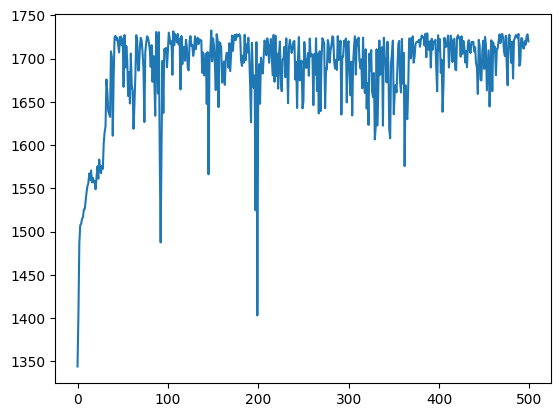

In [ ]:
# update_freq, alpha, tau
# 5, 0.3, 0.01
import numpy as np
import matplotlib.pyplot as plt
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/sac_1.npy")
print(max(a))
plt.plot(a)
plt.show()

1732.0960424960322


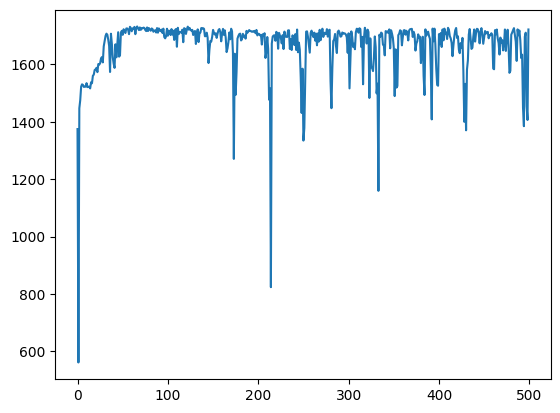

In [ ]:
# update_freq, alpha, tau
# 5, 0.1, 0.01
import numpy as np
import matplotlib.pyplot as plt
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/sac_2.npy")
print(max(a))
plt.plot(a)
plt.show()

1730.3957235378427


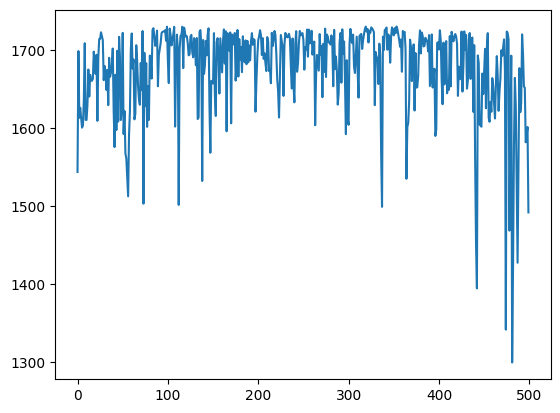

In [ ]:
# update_freq, alpha, tau
# 5, 0.2, 0.01
import numpy as np
import matplotlib.pyplot as plt
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/sac_2.npy")
print(max(a))
plt.plot(a)
plt.show()

1737.2675292265792


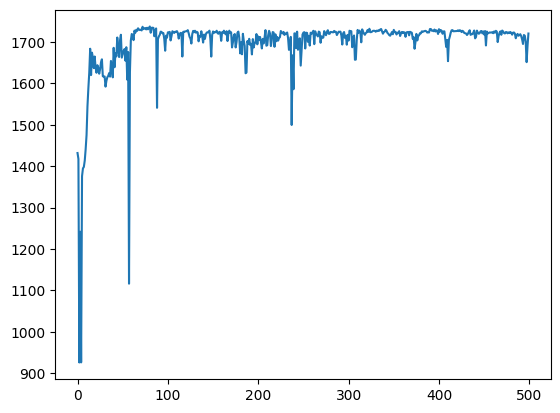

In [ ]:
# update_freq, alpha, tau
# 5, 0.4, 0.01
import numpy as np
import matplotlib.pyplot as plt
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/sac_4.npy")
print(max(a))
plt.plot(a)
plt.show()

In [ ]:
# update_freq, alpha, tau
# 5, 0.4, 0.01
import numpy as np
import matplotlib.pyplot as plt
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/reward/sac_4.npy")
print(max(a))
plt.plot(a)
plt.show()

FileNotFoundError: ignored

1732.3552825651793


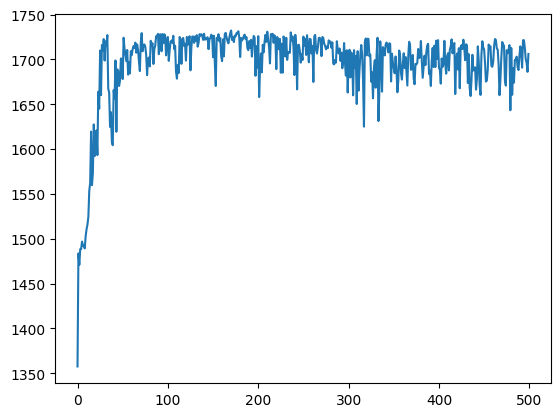

In [ ]:
# update_freq, alpha, tau
# 10, 0.4, 0.01
import numpy as np
import matplotlib.pyplot as plt
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/sac_4.npy")
print(max(a))
plt.plot(a)
plt.show()

1729.8815167805994


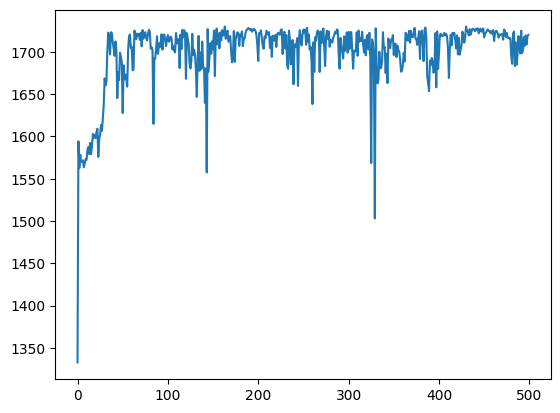

In [ ]:
# update_freq, alpha, tau
# 3, 0.4, 0.01
import numpy as np
import matplotlib.pyplot as plt
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/reward/sac_6.npy")
print(max(a))
plt.plot(a)
plt.show()

1728.815148006681


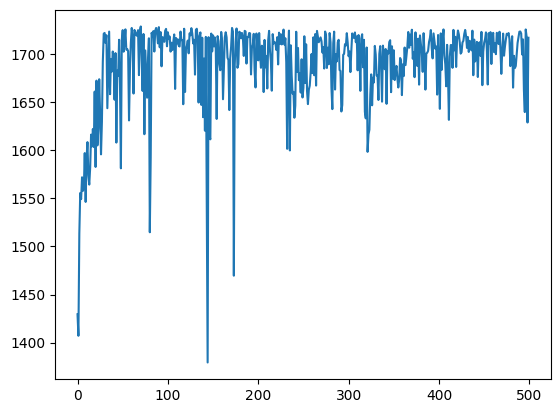

In [ ]:
# update_freq, alpha, tau
# 10, 0.3, 0.01
import numpy as np
import matplotlib.pyplot as plt
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/sac_7.npy")
print(max(a))
plt.plot(a)
plt.show()

1727.628979338331


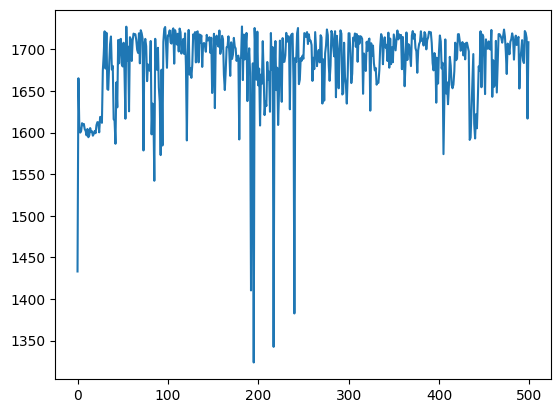

In [ ]:
# update_freq, alpha, tau
# 3, 0.3, 0.01
import numpy as np
import matplotlib.pyplot as plt
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/sac_8.npy")
print(max(a))
plt.plot(a)
plt.show()

1738.6776122904337


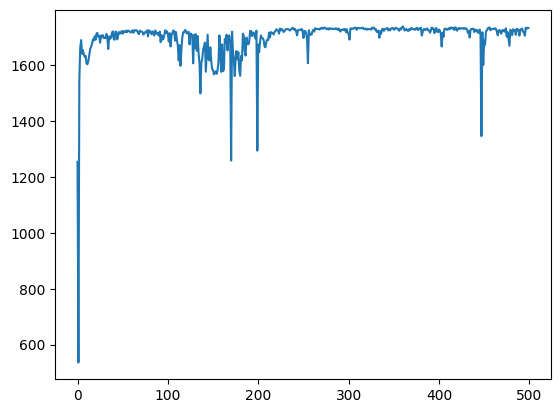

In [ ]:
# update_freq, alpha, tau
# 10, 0.1, 0.01
import numpy as np
import matplotlib.pyplot as plt
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/sac_9.npy")
print(max(a))
plt.plot(a)
plt.show()

1737.224950744165


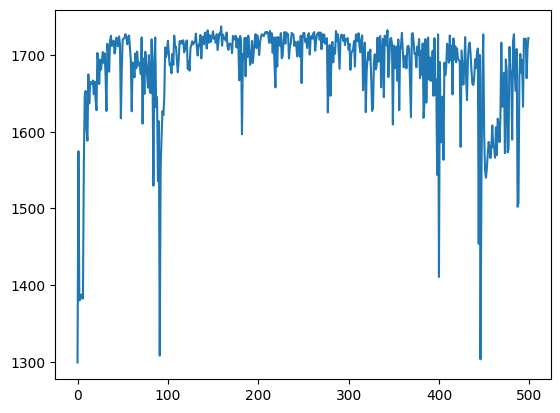

In [ ]:
# update_freq, alpha, tau
# 3, 0.1, 0.01
import numpy as np
import matplotlib.pyplot as plt
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/sac_10.npy")
print(max(a))
plt.plot(a)
plt.show()

1732.547526503783


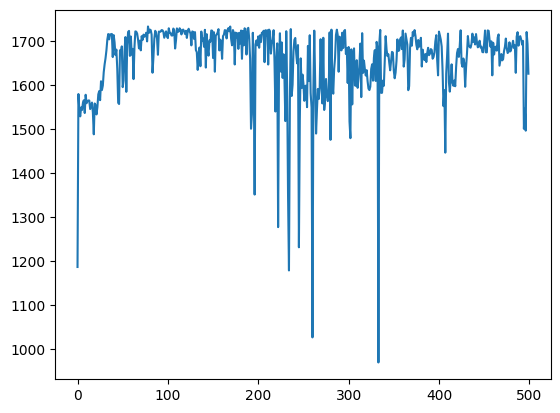

In [ ]:
# update_freq, alpha, tau
# 10, 0.1, 0.005
import numpy as np
import matplotlib.pyplot as plt
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/reward/sac_11.npy")
print(max(a))
plt.plot(a)
plt.show()

이전 SAC

In [ ]:
# action, state network separate
last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)                          # layers dim
    out = layers.Dense(256, activation="relu")(out)                             # layers dim
    outputs = layers.Dense(num_actions, kernel_initializer=last_init)(out)

    # outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out1 = layers.Dense(256, activation="relu")(concat)                         # layers dim
    out2 = layers.Dense(256, activation="relu")(out1)                           # layers dim
    outputs = layers.Dense(1,kernel_initializer=last_init)(out2)
    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

epsilon = 1e-6
LOG_SIG_MIN = -4
LOG_SIG_MAX = 2
def policy(state):
    mean  = mean_actor(state)
    log_std = tf.clip_by_value(logstd_actor(state), LOG_SIG_MIN, LOG_SIG_MAX)
    std = tf.exp(log_std)
    result = [[],[],[]]
    if len(mean) ==1:
      mean = np.squeeze(mean, axis = 0)
      std = np.squeeze(std, axis = 0)

    for i in range(len(mean)):
      normal = tfp.distributions.Normal(mean[i], std[i])
      x_t = normal.sample()
      y_t = tf.tanh(x_t)
      action = y_t
      log_prob = normal.log_prob(x_t)
      log_prob -= tf.math.log((1-y_t**2)+epsilon)
      mean_ = tf.tanh(mean[i])
      result[0].append(action)
      result[1].append(log_prob)
      result[2].append(mean_)
    result[0] = tf.stack(result[0],axis = 0)
    result[1] = tf.stack(result[1],axis = 0)
    result[2] = tf.stack(result[2],axis = 0)
    return result

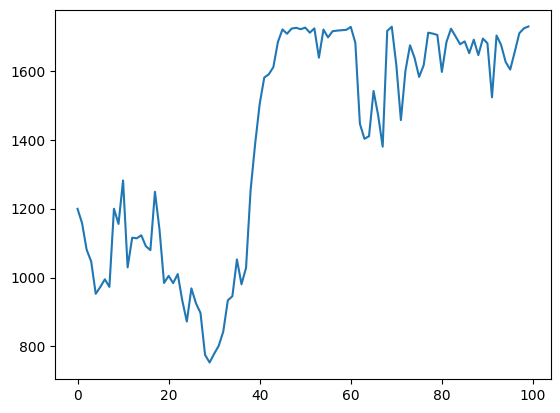

In [ ]:
# steps/update : 30 / alpha : 0.3 / tau : 0.1 / critic_lr : 0.02 / actor_lr : 0.01 / batch size : 64
# Q network, policy network dim 128
import matplotlib.pyplot as plt
import numpy as np
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/baseline0724/reward/1/1_reward.npy")
plt.plot(a)
plt.show()

1707.0092662313307


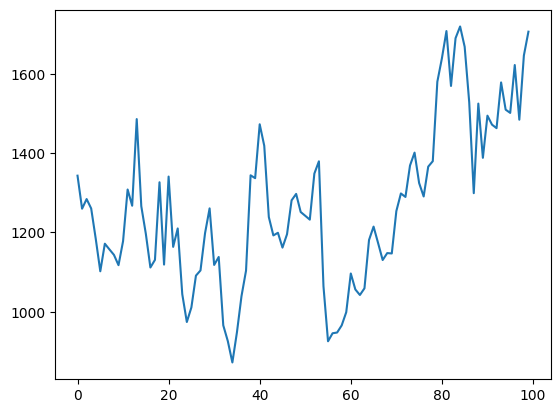

In [ ]:
# steps/update : 30 / alpha : 0.4 / tau : 0.1 / critic_lr : 0.02 / actor_lr : 0.01 / batch size : 64
# Q network, policy network dim 128
import matplotlib.pyplot as plt
import numpy as np
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/baseline0724/reward/2_reward.npy")
print(a[-1])
plt.plot(a)
plt.show()

1483.464603351004


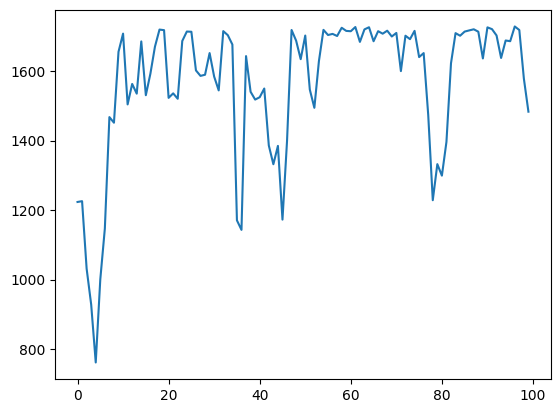

In [ ]:
# steps/update : 30 / alpha : 0.2 / tau : 0.1 / critic_lr : 0.02 / actor_lr : 0.01 / batch size : 64
# Q network, policy network dim 128
import matplotlib.pyplot as plt
import numpy as np
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/baseline0724/reward/3/3_reward.npy")
print(a[-1])
plt.plot(a)
plt.show()

1665.225016968403


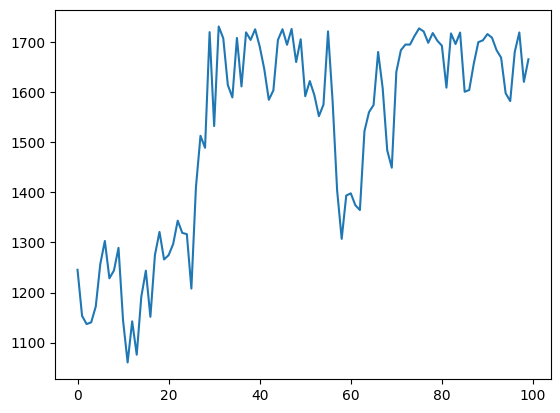

In [ ]:
# steps/update : 20 / alpha : 0.3 / tau : 0.1 / critic_lr : 0.02 / actor_lr : 0.01 / batch size : 64
# Q network, policy network dim 128
import matplotlib.pyplot as plt
import numpy as np
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/baseline0724/reward/4/4_reward.npy")
print(a[-1])
plt.plot(a)
plt.show()

1465.8481167998993


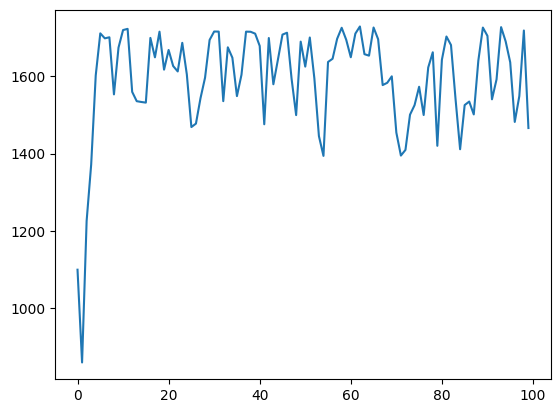

In [ ]:
# steps/update : 30 / alpha : 0.1 / tau : 0.1 / critic_lr : 0.02 / actor_lr : 0.01 / batch size : 64
# Q network, policy network dim 128
import matplotlib.pyplot as plt
import numpy as np
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/baseline0724/reward/5/5_reward.npy")
print(a[-1])
plt.plot(a)
plt.show()

1303.2776362294708


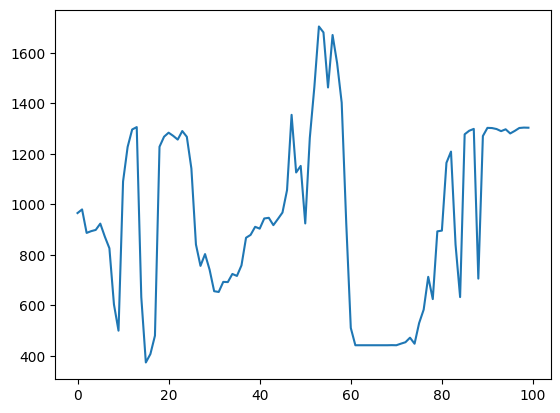

In [ ]:
# steps/update : 30 / alpha : 0.01 / tau : 0.1 / critic_lr : 0.02 / actor_lr : 0.01 / batch size : 64
# Q network, policy network dim 128
import matplotlib.pyplot as plt
import numpy as np
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/baseline0724/reward/6/6_reward.npy")
print(a[-1])
plt.plot(a)
plt.show()

1552.287191351665


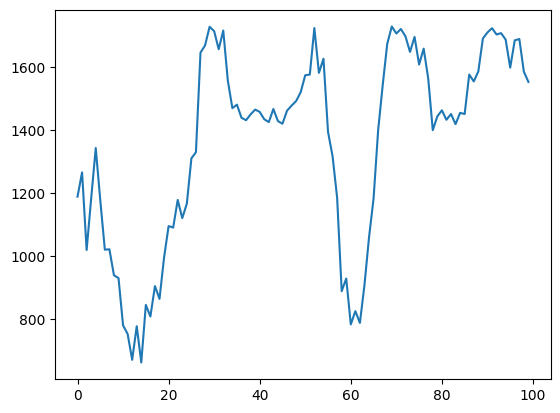

In [ ]:
# steps/update : 30 / alpha : 0.3 / tau : 0.1 / critic_lr : 0.02 / actor_lr : 0.01 / batchsize : 128
# Q network, policy network dim 128
import matplotlib.pyplot as plt
import numpy as np
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/baseline0724/reward/7/7_reward.npy")
print(a[-1])
plt.plot(a)
plt.show()

1719.286600751625


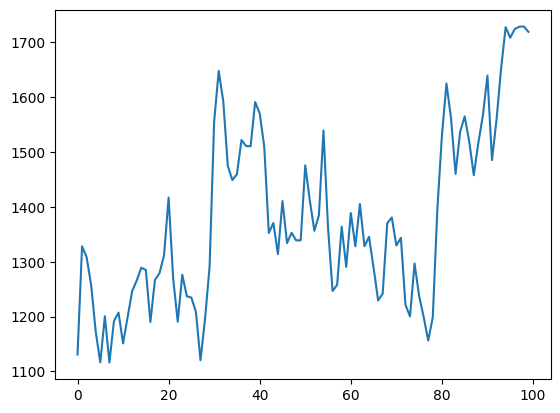

In [ ]:
# steps/update : 60 / alpha : 0.3 / tau : 0.05 / critic_lr : 0.02 / actor_lr : 0.01 / batch size : 64
# Q network, policy network dim 256
import matplotlib.pyplot as plt
import numpy as np
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/baseline0724/reward/8_reward.npy")
print(a[-1])
plt.plot(a)
plt.show()

1511.9700298366472


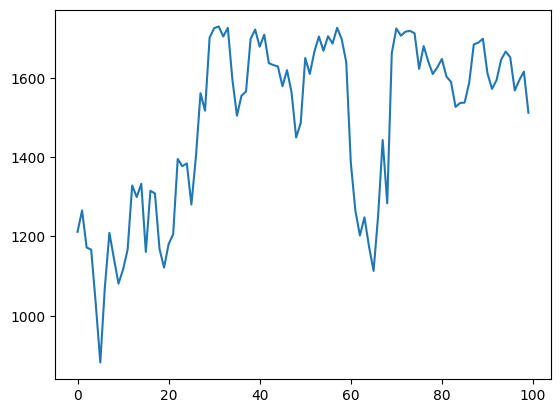

In [ ]:
# steps/update : 30 / alpha : 0.1 / tau : 0.1 / critic_lr : 0.02 / actor_lr : 0.01 / batch size : 64
# Q network, policy network layers dim 128

import matplotlib.pyplot as plt
import numpy as np
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/baseline0724/reward/9_reward.npy")
print(a[-1])
plt.plot(a)
plt.show()

1259.473543114749


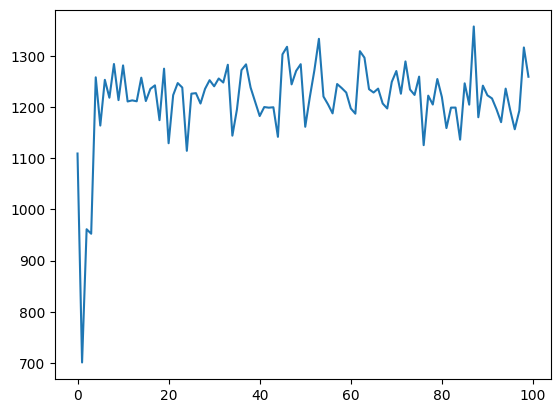

In [ ]:
# steps/update : 30 / alpha : 0.1 / tau : 0.1 / critic_lr : 0.02 / actor_lr : 0.01 / batch size : 64
# Q network, policy network layers dim : 256 / action, state separate

import matplotlib.pyplot as plt
import numpy as np
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/reward/10_reward.npy")
print(a[-1])
plt.plot(a)
plt.show()

1197.3391643571001


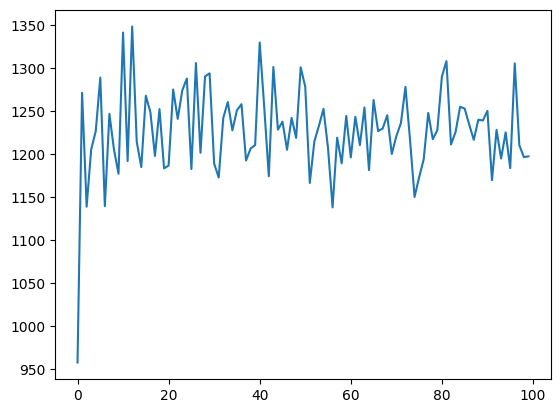

In [ ]:
# steps/update : 30 / alpha : 0.3 / tau : 0.1 / critic_lr : 0.02 / actor_lr : 0.01 / batch size : 64
# Q network, policy network layers dim : 256 / action, state network separate

import matplotlib.pyplot as plt
import numpy as np
a = np.load("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/reward/12_reward.npy")
print(a[-1])
plt.plot(a)
plt.show()

In [ ]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
          self, state_batch, action_batch, reward_batch, next_state_batch
    ):


        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))


        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

        return [critic_loss,actor_loss]

    # We compute the loss and update parameters
    # def learn(self,step):
    #     # Get sampling range
    #     record_range = min(self.buffer_counter, self.buffer_capacity)
    #     # Randomly sample indices
    #     batch_indices = np.random.choice(record_range, self.batch_size)

    #     # Convert to tensors
    #     state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
    #     action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
    #     reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
    #     reward_batch = tf.cast(reward_batch, dtype=tf.float32)
    #     next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

    #     a = self.update(state_batch, action_batch, reward_batch, next_state_batch,step)
    #     return a

    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)
        # return a



# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [ ]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(num_actions, kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    # outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # # State as input
    # state_input = layers.Input(shape=(num_states))
    # state_out = layers.Dense(16, activation="relu")(state_input)
    # state_out = layers.Dense(32, activation="relu")(state_out)

    # # Action as input
    # action_input = layers.Input(shape=(num_actions))
    # action_out = layers.Dense(32, activation="relu")(action_input)

    # # Both are passed through seperate layer before concatenating
    # concat = layers.Concatenate()([state_out, action_out])

    # out = layers.Dense(256, activation="relu")(concat)
    # out = layers.Dense(256, activation="relu")(out)
    # outputs = layers.Dense(1)(out)

    # state_input = layers.Input(shape=(num_states))
    # action_input = layers.Input(shape=(num_actions))
    # Input = layers.Concatenate()([state_input, action_input])
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    Input = layers.Input(shape = (num_states+num_actions))
    out1 = layers.Dense(256, activation="relu")(Input)
    out2 = layers.Dense(256, activation="relu")(out1)
    outputs = layers.Dense(1,kernel_initializer=last_init)(out2)
    # Outputs single value for give state-action
    model = tf.keras.Model(Input, outputs)

    return model

epsilon = 1e-6
LOG_SIG_MIN = -4
LOG_SIG_MAX = 2
def policy(state):
    mean  = mean_actor(state)
    log_std = tf.clip_by_value(logstd_actor(state), LOG_SIG_MIN, LOG_SIG_MAX)
    std = tf.exp(log_std)
    result = [[],[],[]]
    # print(type(mean))
    # print(type(std))
    # print(tf.is_symbolic_tensor(mean)==True)
    # print('mean, std shape')
    # print(mean.shape)
    # print(std.shape)
    # if tf.is_symbolic_tensor(mean)==False:
    if len(mean) ==1:
      mean = np.squeeze(mean, axis = 0)
      std = np.squeeze(std, axis = 0)

    # mean = torch.squeeze(mean)
    # std = torch.squeeze(std)
    for i in range(len(mean)):
      normal = tfp.distributions.Normal(mean[i], std[i])
      x_t = normal.sample()
      y_t = tf.tanh(x_t)
      action = y_t
      log_prob = normal.log_prob(x_t)
      log_prob -= tf.math.log((1-y_t**2)+epsilon)
      mean_ = tf.tanh(mean[i])
      # print('action :',action)
      # print('log_prob : ', log_prob)
      # print('mean : ', mean_)
      result[0].append(action)
      result[1].append(log_prob)
      result[2].append(mean_)
    # print('result')
    result[0] = tf.stack(result[0],axis = 0)
    result[1] = tf.stack(result[1],axis = 0)
    result[2] = tf.stack(result[2],axis = 0)
    # result[0] = tf.convert_to_tensor(result[0])
    # result[0] = tf.convert_to_tensor(result[0])
    # result[0] = tf.convert_to_tensor(result[0])
    # print(result)
    return result



# def select_action(state):
#   state = tf.convert_to_tensor(state, dtype = tf.float32)
#   state = tf.expand_dims(state, axis=0)
#   action, _, _ = policy(state)
#   return action.numpy()[0]

In [ ]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(num_actions, kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    # outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # # State as input
    # state_input = layers.Input(shape=(num_states))
    # state_out = layers.Dense(16, activation="relu")(state_input)
    # state_out = layers.Dense(32, activation="relu")(state_out)

    # # Action as input
    # action_input = layers.Input(shape=(num_actions))
    # action_out = layers.Dense(32, activation="relu")(action_input)

    # # Both are passed through seperate layer before concatenating
    # concat = layers.Concatenate()([state_out, action_out])

    # out = layers.Dense(256, activation="relu")(concat)
    # out = layers.Dense(256, activation="relu")(out)
    # outputs = layers.Dense(1)(out)

    # state_input = layers.Input(shape=(num_states))
    # action_input = layers.Input(shape=(num_actions))
    # Input = layers.Concatenate()([state_input, action_input])
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    Input = layers.Input(shape = (num_states+num_actions))
    out1 = layers.Dense(256, activation="relu")(Input)
    out2 = layers.Dense(256, activation="relu")(out1)
    outputs = layers.Dense(1,kernel_initializer=last_init)(out2)
    # Outputs single value for give state-action
    model = tf.keras.Model(Input, outputs)

    return model

epsilon = 1e-6
LOG_SIG_MIN = -4
LOG_SIG_MAX = 2
def policy(state):
    mean  = mean_actor(state)
    log_std = tf.clip_by_value(logstd_actor(state), LOG_SIG_MIN, LOG_SIG_MAX)
    std = tf.exp(log_std)
    result = [[],[],[]]
    # print(type(mean))
    # print(type(std))
    # print(tf.is_symbolic_tensor(mean)==True)
    # print('mean, std shape')
    # print(mean.shape)
    # print(std.shape)
    # if tf.is_symbolic_tensor(mean)==False:
    if len(mean) ==1:
      mean = np.squeeze(mean, axis = 0)
      std = np.squeeze(std, axis = 0)

    # mean = torch.squeeze(mean)
    # std = torch.squeeze(std)
    for i in range(len(mean)):
      normal = tfp.distributions.Normal(mean[i], std[i])
      x_t = normal.sample()
      y_t = tf.tanh(x_t)
      action = y_t
      log_prob = normal.log_prob(x_t)
      log_prob -= tf.math.log((1-y_t**2)+epsilon)
      mean_ = tf.tanh(mean[i])
      # print('action :',action)
      # print('log_prob : ', log_prob)
      # print('mean : ', mean_)
      result[0].append(action)
      result[1].append(log_prob)
      result[2].append(mean_)
    # print('result')
    result[0] = tf.stack(result[0],axis = 0)
    result[1] = tf.stack(result[1],axis = 0)
    result[2] = tf.stack(result[2],axis = 0)
    # result[0] = tf.convert_to_tensor(result[0])
    # result[0] = tf.convert_to_tensor(result[0])
    # result[0] = tf.convert_to_tensor(result[0])
    # print(result)
    return result



# def select_action(state):
#   state = tf.convert_to_tensor(state, dtype = tf.float32)
#   state = tf.expand_dims(state, axis=0)
#   action, _, _ = policy(state)
#   return action.numpy()[0]

In [ ]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(2, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    # outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

def policy(state,noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.squeeze(legal_action)

In [ ]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 5
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.01

buffer = Buffer(50000, 64)

In [ ]:
# 학습이 잘 되고 있는지 평가할 지표 (모델의 평가지표 아님) (ex epoch마다)
# 학습 데이터 (speed profile)

# # To store reward history of each episode
ep_reward_list = []
# # To store average reward history of last few episodes
avg_reward_list = []



env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
start = time.time()
# r_total = []
# a_total = []

sess = tf.compat.v1.Session()
# Takes about 4 min to train
for ep in range(10):

    done = False

    i=0

    prev_state = env.reset()
    episodic_reward = 0
    # print('########################## ep : {} ############################'.format(ep))

    # train_summary_writer = tf.summary.create_file_writer(f'./runs/({ep})')
    # test_summary_writer = tf.summary.create_file_writer(test_log_dir)

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.convert_to_tensor(prev_state)

        action = policy(tf_prev_state,ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()

        # b = buffer.learn(i)
        # if i%10 == 0:
          # print('----------------------------------------------------------------')
          # print('critic loss : {}'.format(b[0].numpy()))
          # print('actor loss  : {}'.format(b[1].numpy()))

        # with train_summary_writer.as_default():
        #   tf.summary.scalar('critic_loss',b[0].numpy(),step = i)
        #   tf.summary.scalar('actor_loss',b[1].numpy(),step = i)
          # tf.summary.scalar('total reward',episodic_reward,step = i)
          # tf.summary.scalar('Battery SOC',state[0][0],step = i)

        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)


        # End this episode when `done` is True
        if done:
            break

        if i%10000==0:
          print('----------------------------------------------------------------')
          print('ep : {}'.format(ep))
          print('i : {}'.format(i))
          print('state : {}'.format(state))
          print('action : {}'.format(action))
          print('time : {}'.format(time.time()-start))
          print('----------------------------------------------------------------')

        prev_state = state
        i+=1

    ep_reward_list.append(episodic_reward)

    # # Mean of last 40 episodes
    # avg_reward = np.mean(ep_reward_list[-40:])
    # print("Episode * {} * Total Reward is ==> {}".format(ep, np.sum(r_record)))
    # avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards

# plt.plot(np.mean(r_total))
# plt.xlabel("Episode")
# plt.ylabel("Avg. Epsiodic Reward")


# Episodes versus Avg. Rewards
# plt.plot(avg_reward_list)
# plt.xlabel("Episode")
# plt.ylabel("Avg. Epsiodic Reward")
# plt.show()

# print('Avg reward is {}'.format(np.sum(r_total)/total_episodes))
print(time.time()-start)
# plt.show()
# train_summary_writer.close()

----------------------------------------------------------------
ep : 0
i : 0
state : [[0.0134 0.     0.    ]]
action : [0.02203767 0.02203764]
----------------------------------------------------------------
----------------------------------------------------------------
ep : 0
i : 10000
state : [[0.01344446 0.         0.        ]]
action : [1. 1.]
----------------------------------------------------------------
----------------------------------------------------------------
ep : 0
i : 20000
state : [[0.01417427 0.         0.0026    ]]
action : [0.4376562  0.27419362]
----------------------------------------------------------------
----------------------------------------------------------------
ep : 0
i : 30000
state : [[0.01632264 0.05431509 0.00946   ]]
action : [-0.8656543   0.93715136]
----------------------------------------------------------------
----------------------------------------------------------------
ep : 0
i : 40000
state : [[0.0189608  0.05557453 0.00512   ]]
act

In [ ]:
# 학습이 잘 되고 있는지 평가할 지표 (모델의 평가지표 아님) (ex epoch마다)
# 학습 데이터 (speed profile)

# # To store reward history of each episode
ep_reward_list = []
# # To store average reward history of last few episodes
avg_reward_list = []

actor_model.load_weights("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/baseline0724/weights_actor_model.h5")

env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
start = time.time()
# r_total = []
# a_total = []

# sess = tf.compat.v1.Session()
# Takes about 4 min to train
for ep in range(10):

    done = False

    i=0

    prev_state = env.reset()
    episodic_reward = 0
    # print('########################## ep : {} ############################'.format(ep))

    # train_summary_writer = tf.summary.create_file_writer(f'./runs/({ep})')
    # test_summary_writer = tf.summary.create_file_writer(test_log_dir)

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.convert_to_tensor(prev_state)

        action = policy(tf_prev_state,ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        # buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        # buffer.learn()

        # b = buffer.learn(i)
        # if i%10 == 0:
          # print('----------------------------------------------------------------')
          # print('critic loss : {}'.format(b[0].numpy()))
          # print('actor loss  : {}'.format(b[1].numpy()))

        # with train_summary_writer.as_default():
        #   tf.summary.scalar('critic_loss',b[0].numpy(),step = i)
        #   tf.summary.scalar('actor_loss',b[1].numpy(),step = i)
          # tf.summary.scalar('total reward',episodic_reward,step = i)
          # tf.summary.scalar('Battery SOC',state[0][0],step = i)

        # update_target(target_actor.variables, actor_model.variables, tau)
        # update_target(target_critic.variables, critic_model.variables, tau)


        # End this episode when `done` is True
        if done:
            break

        if i%10000==0:
          print('----------------------------------------------------------------')
          print('ep : {}'.format(ep))
          print('i : {}'.format(i))
          print('state : {}'.format(state))
          print('action : {}'.format(action))
          print('time : {}'.format(time.time()-start))
          print('reward : {}'.format(episodic_reward))
          print('----------------------------------------------------------------')

        prev_state = state
        i+=1
    print(episodic_reward)

    # ep_reward_list.append(episodic_reward)

    # # Mean of last 40 episodes
    # avg_reward = np.mean(ep_reward_list[-40:])
    # print("Episode * {} * Total Reward is ==> {}".format(ep, np.sum(r_record)))
    # avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards

# plt.plot(np.mean(r_total))
# plt.xlabel("Episode")
# plt.ylabel("Avg. Epsiodic Reward")


# Episodes versus Avg. Rewards
# plt.plot(avg_reward_list)
# plt.xlabel("Episode")
# plt.ylabel("Avg. Epsiodic Reward")
# plt.show()

# print('Avg reward is {}'.format(np.sum(r_total)/total_episodes))
# print(time.time()-start)
# plt.show()
# train_summary_writer.close()

----------------------------------------------------------------
ep : 0
i : 0
state : [[0.0134 0.     0.    ]]
action : [-0.99269599  1.        ]
time : 0.033410072326660156
----------------------------------------------------------------
----------------------------------------------------------------
ep : 0
i : 10000
state : [[0.01765183 0.         0.        ]]
action : [-1.          0.98769404]
time : 32.657774209976196
----------------------------------------------------------------
----------------------------------------------------------------
ep : 0
i : 20000
state : [[0.01896613 0.04892241 0.0026    ]]
action : [-1.         0.9559527]
time : 64.44438242912292
----------------------------------------------------------------
----------------------------------------------------------------
ep : 0
i : 30000
state : [[0.01898249 0.05569856 0.00946   ]]
action : [-0.7829822  1.       ]
time : 97.0863676071167
----------------------------------------------------------------
---------

KeyboardInterrupt: ignored